<a href="https://colab.research.google.com/github/JamesPeralta/Machine-Learning-Algorithms/blob/master/Miscellaneous/GYMNOS/GymnoDataGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gymno Data Generator
## This class will pull data using the CPU in parallel to the GPU processing the data

In [0]:
# Imports

import pandas as pd
from sklearn.utils import shuffle
import csv
import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from google.colab import drive
import os

In [159]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
## Read in the labels and partitions CSVs

In [0]:
partition = {}
labels = {}

# Load in the Partitions from the CSV
with open("/content/drive/My Drive/GYMNO/Video Dataset/partitions.csv", mode='r') as partitions_csv:
  csv_reader = csv.DictReader(partitions_csv)
  for row in csv_reader:
    dataset_as_string = row["Dataset"]  # Returns Row as a String
    partition[row["Partition"]] = dataset_as_string[2:-2].split("', '")
    

# Load in the Labels from the CSV
with open("/content/drive/My Drive/GYMNO/Video Dataset/labels.csv", mode='r') as labels_csv:
  csv_reader = csv.DictReader(labels_csv)
  for row in csv_reader:
    labels[row["Frame_ID"]] = row["Class"]

In [161]:
print(len(partition["train"]))
print(len(partition["validation"]))
print(len(partition["test"]))

3101
886
444


## Create the DataGenerator

In [0]:
class DataGenerator(keras.utils.Sequence):
  # Initialization
  def __init__(self, list_IDs, labels, data_location, batch_size=32, dim=(32,32,32), n_classes=2, shuffle=True):
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.data_location = data_location
    self.on_epoch_end()
  
  # Updates Indexes after each epoch
  def on_epoch_end(self):
    if self.shuffle == True:
      self.list_IDs = shuffle(self.list_IDs)
      
  # Generates batches of samples from accessing the drive. (n_samples, *dim, channels)
  def __data_generation(self, list_IDs_temp):
    # Initialization
    X = np.empty((self.batch_size, *self.dim))
    y = np.empty((self.batch_size), dtype=int)
    
    # Generate data
    for i, ID in enumerate(list_IDs_temp):
      # Store sample
      X[i,] = np.rot90(plt.imread(self.data_location + ID))
      
      # Store class
      y[i] = self.labels[ID]
      
    return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
  
  # Returns the number of batches we will have per epoch
  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))
  
  # Chooses which labels to retrieve from the drive
  def __getitem__(self, index):

    # Generate data
    X, y = self.__data_generation(self.list_IDs[index*self.batch_size:(index+1)*self.batch_size])

    return X, y

---
## Using the DataGenerator

In [0]:
# Parameters
params = {'data_location': "/content/drive/My Drive/GYMNO/Video Dataset/Test/",
          'dim': (224, 224, 3),
          'batch_size': 32,
          'n_classes': 2,
          'shuffle': True}

myGenerator = DataGenerator(partition["test"], labels, **params)

here


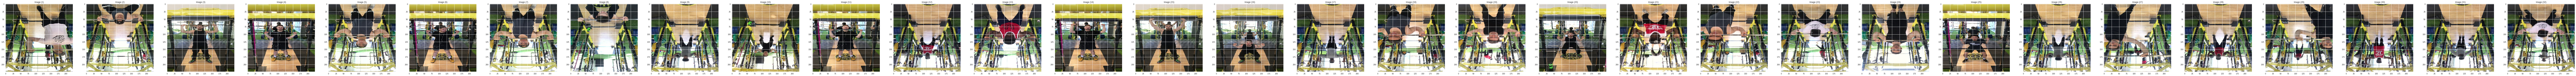

In [165]:
images, labels = myGenerator.__getitem__(1)

array_images = []
for index, image in enumerate(images):
  array_images.append(images[index].astype(int))
  
print("here")
show_images(array_images)

---
## Additonal functions

In [0]:
# Plot multiple images with matplotlib in a single figure. Titles can be given optionally as second argument.

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()